<a href="https://colab.research.google.com/github/LiQuinChing/DL-ReinforcementLearningPart2/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [1]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [2]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 20
        self.width = 20
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

Setup: state helpers, action map, and Replay Buffer

In [3]:
import numpy as np
import random
import collections
import matplotlib.pyplot as plt

# If PyTorch isn't imported yet
import torch
import torch.nn as nn
import torch.optim as optim

# ---- Helpers to map between GridWorld state and model inputs ----
def state_to_index(env, loc):
    x, y = loc
    return x * env.width + y

def index_to_onehot(idx, n):
    v = np.zeros(n, dtype=np.float32)
    v[idx] = 1.0
    return v

def obs_vector(env, loc):
    # One-hot over all cells (8x8 -> 64), general for any HxW
    idx = state_to_index(env, loc)
    return index_to_onehot(idx, env.height * env.width)

# ---- Action mapping: env expects strings; model uses 0..3 ----
ACTION_STR = ['UP', 'DOWN', 'LEFT', 'RIGHT']
A = len(ACTION_STR)

# ---- Simple replay buffer ----
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buf = collections.deque(maxlen=capacity)
    def push(self, s, a, r, s1, done):
        self.buf.append((s, a, r, s1, done))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s, a, r, s1, d = map(np.array, zip(*batch))
        return s, a, r.astype(np.float32), s1, d.astype(np.float32)
    def __len__(self):
        return len(self.buf)


DQN model and training utilities

In [4]:
class DQNNet(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        # Small MLP is enough for GridWorld
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    def forward(self, x):
        return self.net(x)

@torch.no_grad()
def select_action(qnet, s_vec, epsilon):
    # ε-greedy on current Q(s,·)
    if np.random.rand() < epsilon:
        return np.random.randint(A)
    s_t = torch.tensor(s_vec, dtype=torch.float32).unsqueeze(0)  # [1, S]
    q = qnet(s_t)                                                # [1, A]
    a = int(torch.argmax(q, dim=1).item())
    return a

def soft_update(target, online, tau=0.005):
    # θ_target ← τ θ_online + (1-τ) θ_target
    with torch.no_grad():
        for t_param, o_param in zip(target.parameters(), online.parameters()):
            t_param.data.mul_(1 - tau).add_(tau * o_param.data)


Training loop for a single epsilon

In [5]:
def train_dqn(env_ctor,  # pass the GridWorld class (or a lambda that returns a new env)
              episodes=2000,
              max_steps=200,
              epsilon=0.5,
              gamma=0.99,
              lr=1e-3,
              batch_size=64,
              start_learning=1000,
              target_update=200,     # hard update period (in steps); set None to use soft_update
              tau=None,              # soft update factor if you prefer; e.g., 0.01
              buffer_capacity=50000,
              seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    # Fresh env per run
    env = env_ctor()

    S = env.height * env.width
    online = DQNNet(S, A)
    target = DQNNet(S, A)
    target.load_state_dict(online.state_dict())
    optimizer = optim.Adam(online.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss()

    buffer = ReplayBuffer(buffer_capacity)

    # Logging
    ep_rewards = []
    losses = []

    global_step = 0

    for ep in range(episodes):
        # reset environment at the start of each episode
        env.__init__()  # GridWorld resets start location randomly
        s_vec = obs_vector(env, env.current_location)
        total_reward = 0.0

        for t in range(max_steps):
            # ε-greedy
            a_idx = select_action(online, s_vec, epsilon)
            action_str = ACTION_STR[a_idx]

            # step
            r = env.make_step(action_str)
            s1_vec = obs_vector(env, env.current_location)
            done = (env.check_state() == 'TERMINAL')

            # store transition
            buffer.push(s_vec, a_idx, r, s1_vec, float(done))
            total_reward += r
            s_vec = s1_vec
            global_step += 1

            # learn
            if len(buffer) >= start_learning:
                s_b, a_b, r_b, s1_b, d_b = buffer.sample(batch_size)

                s_b_t  = torch.tensor(s_b, dtype=torch.float32)        # [B, S]
                a_b_t  = torch.tensor(a_b, dtype=torch.long).unsqueeze(1) # [B, 1]
                r_b_t  = torch.tensor(r_b, dtype=torch.float32).unsqueeze(1) # [B, 1]
                s1_b_t = torch.tensor(s1_b, dtype=torch.float32)       # [B, S]
                d_b_t  = torch.tensor(d_b, dtype=torch.float32).unsqueeze(1) # [B, 1]

                # Q(s,a)
                q_pred = online(s_b_t).gather(1, a_b_t)  # [B,1]

                with torch.no_grad():
                    # Double-DQN style target (optional but helps): a* from online, value from target
                    a_star = torch.argmax(online(s1_b_t), dim=1, keepdim=True)  # [B,1]
                    q_next = target(s1_b_t).gather(1, a_star)                   # [B,1]
                    q_tgt  = r_b_t + gamma * (1.0 - d_b_t) * q_next

                loss = loss_fn(q_pred, q_tgt)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(online.parameters(), 5.0)
                optimizer.step()

                losses.append(loss.item())

                # Target network update
                if target_update is not None and global_step % target_update == 0:
                    target.load_state_dict(online.state_dict())
                elif tau is not None:
                    soft_update(target, online, tau=tau)

            if done:
                break

        ep_rewards.append(total_reward)

        # (optional) simple progress print
        if (ep+1) % 200 == 0:
            avg = np.mean(ep_rewards[-200:])
            print(f"epsilon={epsilon:.2f} | episode={ep+1}/{episodes} | avg_reward(200)={avg:.2f}")

    return {
        "rewards": ep_rewards,
        "losses": losses,
        "online": online,
        "target": target
    }


Run comparisons for different epsilons and plot


=== Training DQN with epsilon=0.1 ===
epsilon=0.10 | episode=200/2000 | avg_reward(200)=-16.08
epsilon=0.10 | episode=400/2000 | avg_reward(200)=3.88
epsilon=0.10 | episode=600/2000 | avg_reward(200)=-0.93
epsilon=0.10 | episode=800/2000 | avg_reward(200)=3.71
epsilon=0.10 | episode=1000/2000 | avg_reward(200)=3.83
epsilon=0.10 | episode=1200/2000 | avg_reward(200)=3.95
epsilon=0.10 | episode=1400/2000 | avg_reward(200)=3.67
epsilon=0.10 | episode=1600/2000 | avg_reward(200)=3.88
epsilon=0.10 | episode=1800/2000 | avg_reward(200)=4.25
epsilon=0.10 | episode=2000/2000 | avg_reward(200)=3.51

=== Training DQN with epsilon=0.5 ===
epsilon=0.50 | episode=200/2000 | avg_reward(200)=-20.93
epsilon=0.50 | episode=400/2000 | avg_reward(200)=-5.99
epsilon=0.50 | episode=600/2000 | avg_reward(200)=-5.80
epsilon=0.50 | episode=800/2000 | avg_reward(200)=-6.47
epsilon=0.50 | episode=1000/2000 | avg_reward(200)=-4.93
epsilon=0.50 | episode=1200/2000 | avg_reward(200)=-5.67
epsilon=0.50 | episode=1

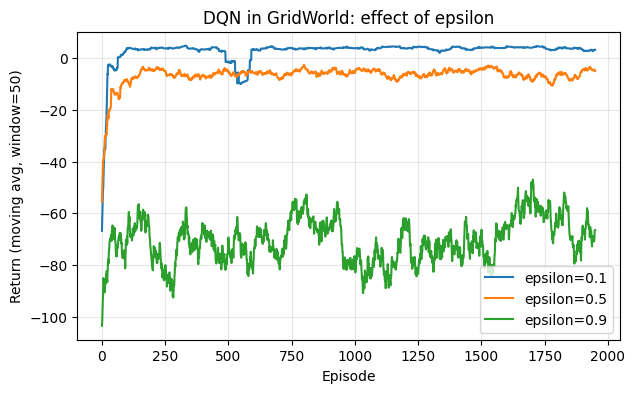

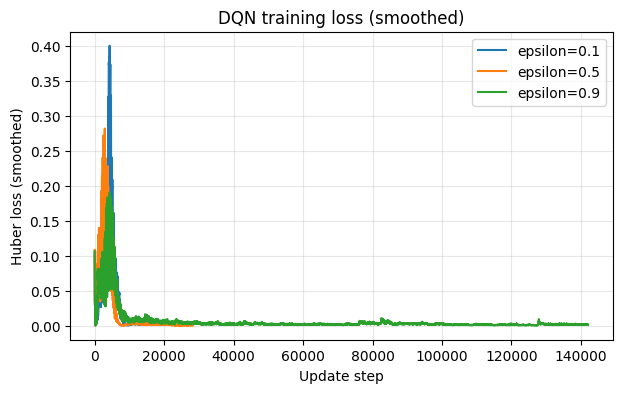

In [6]:
# Make sure GridWorld class is defined as in your notebook
def env_ctor():
    return GridWorld()

epsilons = [0.1, 0.5, 0.9]
histories = {}

for eps in epsilons:
    print(f"\n=== Training DQN with epsilon={eps} ===")
    histories[eps] = train_dqn(
        env_ctor,
        episodes=2000,    # you can tune this
        max_steps=200,
        epsilon=eps,
        gamma=0.99,
        lr=1e-3,
        batch_size=64,
        start_learning=500,   # start learning sooner for small tasks
        target_update=200,    # hard update every 200 steps (or set tau=0.01 for soft)
        tau=None,
        buffer_capacity=20000,
        seed=0
    )

# Plot smoothed returns to compare
def moving_avg(x, w=50):
    if len(x) < w:
        return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(7,4))
for eps in epsilons:
    r = histories[eps]["rewards"]
    plt.plot(moving_avg(r, 50), label=f"epsilon={eps}")
plt.xlabel("Episode")
plt.ylabel("Return (moving avg, window=50)")
plt.title("DQN in GridWorld: effect of epsilon")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# (Optional) Plot training loss curves (noisy but sometimes informative)
plt.figure(figsize=(7,4))
for eps in epsilons:
    ls = histories[eps]["losses"]
    if len(ls) > 0:
        plt.plot(moving_avg(ls, 100), label=f"epsilon={eps}")
plt.xlabel("Update step")
plt.ylabel("Huber loss (smoothed)")
plt.title("DQN training loss (smoothed)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
